In [1]:
import sys
sys.path.append("/home/raulteixeira/repos/CSPZ/scripts/")
import NoiseSOM as ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

In [2]:
n = 48 # size of SOM
path_data = "/project2/chihway/raulteixeira/data/"
som_weights = np.load("%s/som_deep_48_48_5e5.npy"%path_data,allow_pickle=True)

nTrain=5e5
hh = ns.hFunc(nTrain,sigma=(30,1))
metric = ns.AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
som = ns.NoiseSOM(metric,None,None, \
    learning=hh, \
    shape=(48,48), \
    wrap=False,logF=True, \
    initialize=som_weights, \
    minError=0.02)

In [8]:
start_time = time.time()

def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table(path_data+'deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

deep_data=df

deep_data.loc[:,"BDF_MAG_DERED_CALIB_I"]=flux2mag(deep_data.loc[:, 'BDF_FLUX_DERED_CALIB_I'])

def balrog_sigmoid(x, x0):
    """Sigmoid function
    Parameters
    ----------
    x : float or array-like
        Points at which to evaluate the function.
    x0 : float or array-like
        Location of transition.
    Returns
    -------
    sigmoid : scalar or array-like, same shape as input
    """
    return 1.0 - 1.0 / (1.0 + np.exp(-4.0 * (x - x0)))

def mock_balrog_sigmoid(
    deep_data, 
    sigmoid_x0,
    N,
    ref_mag_col = "BDF_MAG_DERED_CALIB_I"
):
    """
    Function for selecting deep field galaxies at a rate that follows a sigmoid function that smoothly transitions from 1 for bright objects, to a value of 0 for faint objects. 
    Parameters
    ----------
    deep_data : pandas dataframe
        Pandas dataframe containing the deep field data.
    sigmoid_x0 : float
        Magnitude value at which the sigmoid function transitions from 1 to 0.
    N : int
        Number of galaxies to be drawn.
    ref_mag_col : string
        Column name of the reference magnitude in deep_data
    Returns
    -------
    deep_balrog_selection : pandas dataframe
        Pandas dataframe containing a list of N deep field objects to be injected by Balrog.
    """
    np.random.seed()
    mag_ref = deep_data.loc[:, ref_mag_col].values
    weights = balrog_sigmoid(mag_ref, sigmoid_x0)
    weights/=sum(weights)
    selected_objects = np.random.choice(len(deep_data), N, p=weights, replace=True)
    
    deep_balrog_selection = deep_data.iloc[selected_objects]
    return deep_balrog_selection

nTrain = int(5e5)
deep_balrog_mocked = mock_balrog_sigmoid(deep_data, 23.0, nTrain)

bands = ['U','G','R','I','Z','J','H','KS']
fluxes_d = np.zeros((len(deep_balrog_mocked),len(bands)))
fluxerrs_d = np.zeros((len(deep_balrog_mocked),len(bands)))

for i,band in enumerate(bands):
    fluxes_d[:,i] = deep_balrog_mocked['BDF_FLUX_DERED_CALIB_%s'%band]
    fluxerrs_d[:,i] = deep_balrog_mocked['BDF_FLUX_ERR_DERED_CALIB_%s'%band]

print("--- %s seconds ---" % (time.time() - start_time))

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- 18.07727837562561 seconds ---


In [9]:
data = pd.read_csv('%s/deep_fields_nice_n_z.csv.gz'%path_data)

In [10]:
data.columns

Index(['Unnamed: 0', 'ID', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I', 'cells', 'u-g',
       'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'i', 'u-i', 'g-i', 'z-i',
       'j-i', 'h-i', 'ks-i', 'zspec', 'paus_z', 'cosmos_z', 'Z', 'good_Z'],
      dtype='object')

In [11]:
def good_len(a):
    """
    returns number of non nan values
    """
    return np.sum(~np.isnan(a))
    
features = ['i', 'u-g', 'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'good_Z', 'Z', 'zspec', 'paus_z', 'cosmos_z']
squares = {feat: (data[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len, good_len]))[feat] for feat in features}

In [108]:
# getting p(z|C)
z_sample_cells = [data['Z'][data['cells'].values==cell_no].values for cell_no in range(n**2)]

#np.arange(n**2)[np.array([len(z_sample_cell) for z_sample_cell in z_sample_cells_clean])==0]

z_sample_cells_clean = [z_sample_cell[~np.isnan(z_sample_cell)] for z_sample_cell in z_sample_cells]

bin_info = [np.histogram(z_sample_cell, bins='auto', density=True) for z_sample_cell in z_sample_cells_clean]

bins_v, bins_e = np.array(bin_info)[:,0], np.array(bin_info)[:,1]

bins_c = []
for i, bins in enumerate(bins_e):
    bin_c = [bins[i]+.5*(bins[i+1]-bins[i]) for i in range(len(bins)-1)]
    bins_c.append(bin_c)

p_z_Cs = np.array([np.interp(np.linspace(0,3.5,100), bin_c, bin_v, left=0, right=0)\
                   for (bin_c, bin_v) in zip(bins_c, bins_v)])
ln_p_z_Cs = np.full_like(p_z_Cs, -300)
ln_p_z_Cs[p_z_Cs>0]=np.log(p_z_Cs[p_z_Cs>0])

p_C.reshape(n**2,1)*p_z_Cs

#plt.plot(np.linspace(0,3.5,100), np.log(np.sum(p_C.reshape(n**2,1)*p_z_Cs, axis=0)))
#plt.show()

prior = p_C.reshape(n**2,1)*p_z_Cs
lnpriors = np.full_like(prior, -300)
lnpriors[prior>0] = np.log(prior[prior>0])
lnprior = np.sum(lnpriors, axis=0)
lnprior /= np.sum(lnprior)

lnposterior = np.sum(lnpriors + .5*chi2, axis=0)
lnposterior /= np.cumsum(lnposterior)[-1]

lnprior.max()

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


0.011582359643517452

157124
174642
424577
35928
90713
252517
309917
357815
55315


/home/raulteixeira/repos/CSPZ/scripts/NoiseSOM.py:353: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)


358729


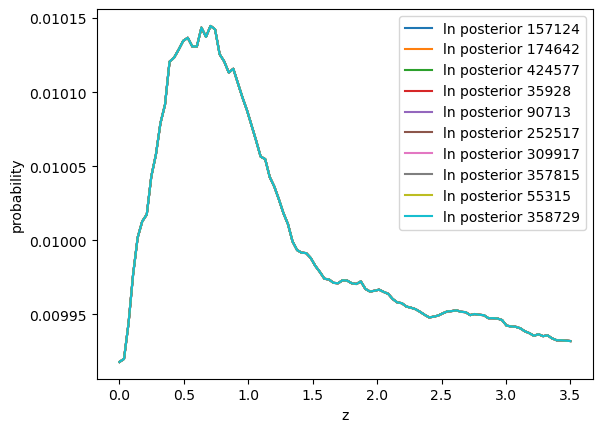

In [110]:
for index in np.random.randint(0, int(5e5), 10):
    chi2 = som.chisq(fluxes_d[index], fluxerrs_d[index])

    print(index)
    im = chi2.reshape(n,n)
    #plt.imshow(im, norm=LogNorm(), cmap='YlGnBu')
    #plt.colorbar()

    # getting p(C)

    z_counts = squares['Z']['good_len'].values
    p_C = z_counts/np.sum(z_counts) #capital C is c-hat
    ln_p_C = np.full_like(p_C, -300)
    ln_p_C[p_C>0]=np.log(p_C[p_C>0])

    #im = ln_p_C.reshape(n,n)
    #plt.imshow(im)
    #plt.colorbar()

    np.sum(lnposterior)

    plt.plot(np.linspace(0,3.5,100), lnposterior, label=f'ln posterior {index}')
    plt.xlabel('z')
    plt.ylabel('probability')
    #plt.plot(np.linspace(0,3.5,100), (-lnprior+lnprior.max())/np.sum(-lnprior+lnprior.max()), label=f'ln prior {index}')
    plt.legend()
plt.show()

In [25]:
np.savetxt('%s/p_C_1st_attempt.txt'%path_data, p_C)
np.savetxt('%s/p_z_Cs_1st_attempt.txt'%path_data, p_z_Cs)

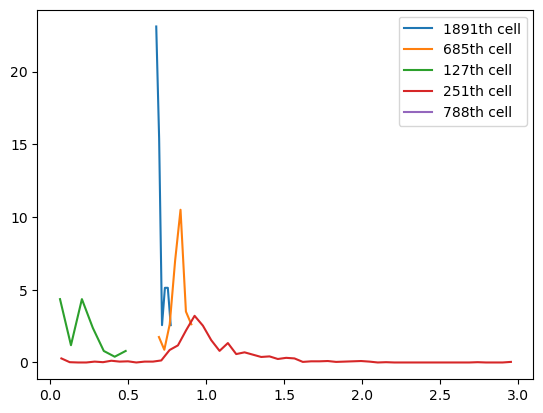

In [32]:
for i in np.random.randint(n**2, size=5):
    plt.plot(bins_c[i], bins_v[i], label=f'{i}th cell')
    plt.legend()
plt.show()

600


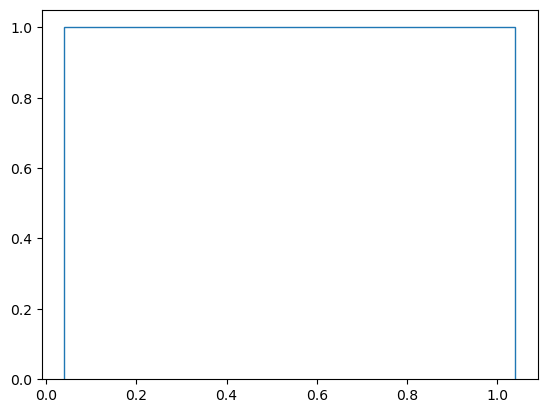

In [27]:
cell_no = np.random.randint(0,n**2)
print(cell_no)
h_bins, bins, patches = plt.hist(z_sample_cells[cell_no], histtype='step', density=True, bins='auto')
bin_c = [bins[i]+.5*(bins[i+1]-bins[i]) for i in range(len(bins)-1)]

plt.plot(bin_c, h_bins)

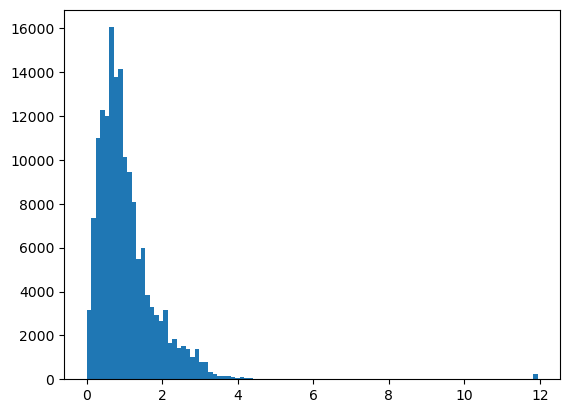

In [61]:
plt.hist(data['Z'], bins=100);

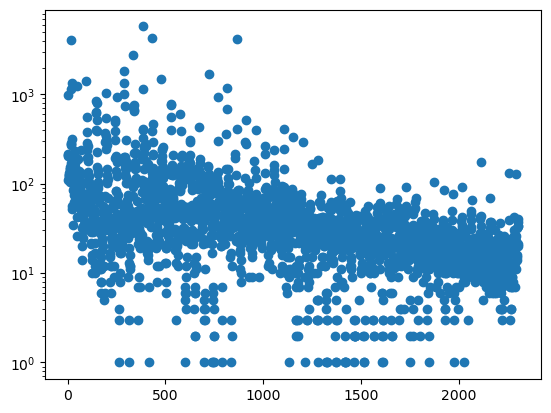

In [30]:
plt.scatter(range(n**2),z_counts)
plt.yscale('log')